In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pizza-not-pizza/pizza_not_pizza/food101_subset.py
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/2374305.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/2415437.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/1123352.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/2294128.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/215349.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/938244.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/444123.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/884964.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/2394770.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/901984.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/117282.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/1227349.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/1743531.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/21

### Import Libaries and Dependencies


In [2]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import pandas

### Load Dataset


In [3]:
train_dir = '/kaggle/input/pizza-not-pizza/pizza_not_pizza/'

In [4]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=32,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 1966 files belonging to 2 classes.
Using 1573 files for training.


2022-08-16 14:02:08.544497: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=32,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 1966 files belonging to 2 classes.
Using 393 files for validation.


In [6]:
class_names = train_data.class_names
print(class_names)

['not_pizza', 'pizza']


### Visualise the Data

2022-08-16 14:02:08.908858: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


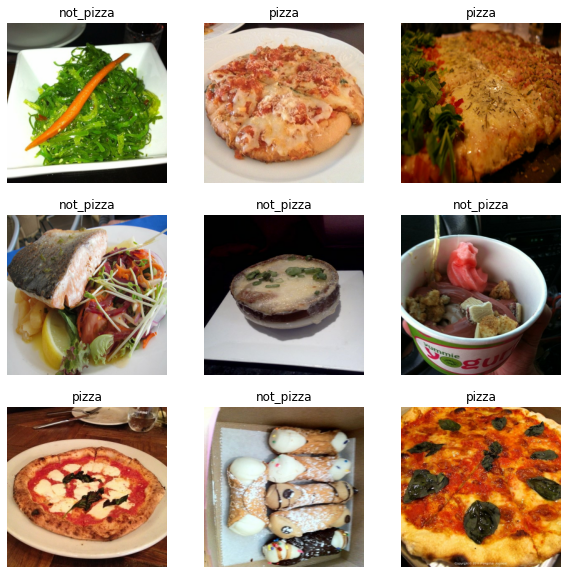

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("int32"))
    plt.title(class_names[labels[i]])
    plt.axis("off")